### Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum
# import seaborn as sns # improves plot aesthetics

### Classes

In [11]:
class AxisType(Enum):
    Continuous = 1  
    Categorical = 2 

@dataclass
class Axis:
    title: str
    type: AxisType
    range: list


### Data

In [24]:
axes = [
    Axis(
        "Words Per Minute (WPM)",
        AxisType.Continuous,
        [0,80]
    ),
    Axis(
        "Total Error Rate",
        AxisType.Continuous,
        [0,1]
    ),
    Axis(
        "Flight Time",
        AxisType.Continuous,
        [0,100]
    ),
    Axis(
        "Hold Time",
        AxisType.Continuous,
        [0,100]
    ),
    Axis(
        "Suggestions",
        AxisType.Continuous,
        [0,100]
    ),
    Axis(
        "Autocorrect",
        AxisType.Continuous,
        [0,100]
    )
]

# the number of columns should match the number of axes
# order is determined by the defined axes

data = {
    'ExpT': [38, .2, 80, 40, 22, 66],
    'ExpC': [1, .8, 22, 76, 100, 23],
    'PasS': [90, .99, 1, 90, 90, 2],
    'Transcriptions': [50, .5, 100, 34, 55, 5],
}

df = pd.DataFrame(index=[x.title for x in axes],data=data)

print(df)
 

                        ExpT   ExpC   PasS  Transcriptions
Words Per Minute (WPM)  38.0    1.0  90.00            50.0
Total Error Rate         0.2    0.8   0.99             0.5
Flight Time             80.0   22.0   1.00           100.0
Hold Time               40.0   76.0  90.00            34.0
Suggestions             22.0  100.0  90.00            55.0
Autocorrect             66.0   23.0   2.00             5.0


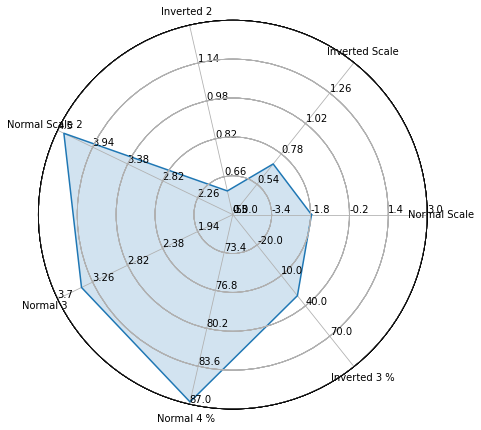

In [8]:

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    # for d, (y1, y2) in zip(data[1:], ranges[1:]):
    for d, (y1, y2) in zip(data, ranges):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)

    x1, x2 = ranges[0]
    d = data[0]

    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1

    sdata = [d]

    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1

        sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)

    return sdata

def set_rgrids(self, radii, labels=None, angle=None, fmt=None,
               **kwargs):
    """
    Set the radial locations and labels of the *r* grids.
    The labels will appear at radial distances *radii* at the
    given *angle* in degrees.
    *labels*, if not None, is a ``len(radii)`` list of strings of the
    labels to use at each radius.
    If *labels* is None, the built-in formatter will be used.
    Return value is a list of tuples (*line*, *label*), where
    *line* is :class:`~matplotlib.lines.Line2D` instances and the
    *label* is :class:`~matplotlib.text.Text` instances.
    kwargs are optional text properties for the labels:
    %(Text)s
    ACCEPTS: sequence of floats
    """
    # Make sure we take into account unitized data
    radii = self.convert_xunits(radii)
    radii = np.asarray(radii)
    rmin = radii.min()
    # if rmin <= 0:
    #     raise ValueError('radial grids must be strictly positive')

    self.set_yticks(radii)
    if labels is not None:
        self.set_yticklabels(labels)
    elif fmt is not None:
        self.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    if angle is None:
        angle = self.get_rlabel_position()
    self.set_rlabel_position(angle)
    for t in self.yaxis.get_ticklabels():
        t.update(kwargs)
    return self.yaxis.get_gridlines(), self.yaxis.get_ticklabels()

class ComplexRadar():
    def __init__(
        self, fig, variables, ranges, n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            # ax.set_rgrids(grid, labels=gridlabel, angle=angles[i])
            set_rgrids(ax, grid, labels=gridlabel, angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


# example data
variables = ("Normal Scale", "Inverted Scale", "Inverted 2", 
            "Normal Scale 2", "Normal 3", "Normal 4 %", "Inverted 3 %")
data = (-1.76, 1.1, 1.2, 
        4.4, 3.4, 86.8, 20)
ranges = [(-5, 3), (1.5, 0.3), (1.3, 0.5),
         (1.7, 4.5), (1.5, 3.7), (70, 87), (100, -50)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()
